# Preprocessing

In [1]:
import os
import yaml
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

## Load Configuration File

In [2]:
os.chdir('/home/febbyngrni/telco_churn')
os.getcwd()

'/home/febbyngrni/telco_churn'

In [3]:
params_dir = 'config/config.yaml'

In [4]:
def load_params(params_dir):
    with open(params_dir, 'r') as file:
        params = yaml.safe_load(file)

    return params

In [5]:
params = load_params(params_dir)

## Load Dataset

In [119]:
def load_dataset(config_data: dict):
    X_train = joblib.load(config_data['train_set_path'][0])
    y_train = joblib.load(config_data['train_set_path'][1])

    X_valid = joblib.load(config_data['valid_set_path'][0])
    y_valid = joblib.load(config_data['valid_set_path'][1])

    X_test = joblib.load(config_data['test_set_path'][0])
    y_test = joblib.load(config_data['test_set_path'][1])

    train_set = pd.concat([X_train, y_train], axis=1)
    valid_set = pd.concat([X_valid, y_valid], axis=1)
    test_set = pd.concat([X_test, y_test], axis=1)

    return train_set, valid_set, test_set

In [120]:
train_set, valid_set, test_set = load_dataset(config_data=params)

In [121]:
train_set.head()

,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
5557,Female,No,No,No,5,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,No,Electronic check,80.20,384.25,No
2270,Female,Yes,No,No,3,Yes,No,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,86.85,220.95,Yes
6930,Female,No,Yes,No,3,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.15,216.75,Yes
2257,Female,No,No,No,60,Yes,Yes,DSL,No,No,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),80.55,4847.05,No
898,Female,No,No,No,12,Yes,No,Fiber optic,Yes,No,No,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),98.90,1120.95,Yes


## One Hot Encoding

In [122]:
def ohe_fit(config_file):
    for col in config_file['predictors_categorical']:
        ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        ohe.fit(np.array(config_file['range_' + col]).reshape(-1,1))
        joblib.dump(ohe, config_file['ohe_' + col + '_path'])

In [123]:
ohe_fit(config_file=params)

In [124]:
def ohe_transform(data, config_file):
    data_copy = data.copy()

    for col in config_file['predictors_categorical']:
        ohe = joblib.load(config_file['ohe_' + col + '_path'])
        ohe_features = ohe.transform(np.array(data_copy[col].to_list()).reshape(-1,1))

        column_name = ohe.get_feature_names_out([col])
        ohe_features = pd.DataFrame(ohe_features, columns=column_name)

        ohe_features.set_index(data_copy.index, inplace = True)
        data_copy = pd.concat([ohe_features, data_copy], axis=1)
        data_copy.drop(columns=col, inplace=True)

    return data_copy

In [125]:
train_set = ohe_transform(data=train_set, config_file=params)
train_set.head()

,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,paperless_billing_Yes,contract_One year,contract_Two year,streaming_movies_No internet service,streaming_movies_Yes,streaming_tv_No internet service,streaming_tv_Yes,...,multiple_lines_Yes,phone_service_Yes,dependents_Yes,partner_Yes,senior_citizen_Yes,gender_Male,tenure_months,monthly_charges,total_charges,churn
5557,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5,80.20,384.25,No
2270,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,3,86.85,220.95,Yes
6930,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,3,75.15,216.75,Yes
2257,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,60,80.55,4847.05,No
898,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,12,98.90,1120.95,Yes


In [126]:
valid_set = ohe_transform(data=valid_set, config_file=params)

In [127]:
test_set = ohe_transform(data=test_set, config_file=params)

## Label Balancing

<Axes: xlabel='churn', ylabel='Count'>

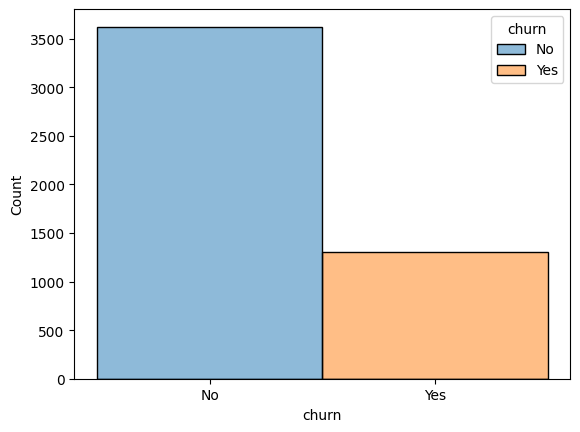

In [128]:
sns.histplot(data=train_set, x='churn', hue='churn')

### Undersampling

In [129]:
def rus_resample(data, col_to_drop):
    data_copy = data.copy()

    rus = RandomUnderSampler(random_state=42)
    X_rus, y_rus = rus.fit_resample(data_copy.drop(col_to_drop, axis=1), data_copy[col_to_drop])
    data_rus = pd.concat([X_rus, y_rus], axis=1)

    return data_rus

In [130]:
data_rus = rus_resample(data=train_set, col_to_drop='churn')

<Axes: xlabel='churn', ylabel='Count'>

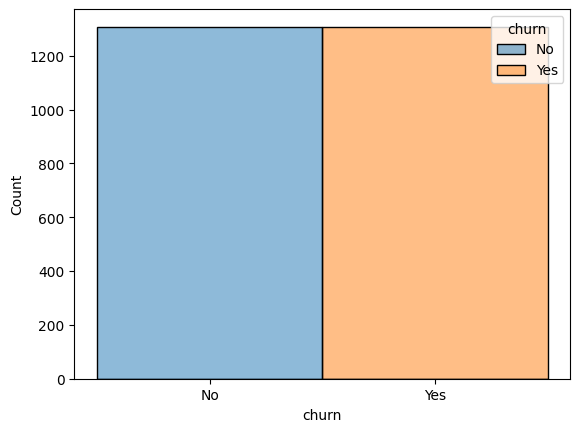

In [131]:
sns.histplot(data=data_rus, x='churn', hue='churn')

In [132]:
train_set['churn'].value_counts()

churn
No     3622
Yes    1308
Name: count, dtype: int64

### Oversampling

In [133]:
def ros_resample(data, col_to_drop):
    data_copy = data.copy()

    ros = RandomOverSampler(random_state=11)
    X_ros, y_ros = ros.fit_resample(data_copy.drop(col_to_drop, axis=1), data_copy[col_to_drop])
    data_ros = pd.concat([X_ros, y_ros], axis=1)

    return data_ros

In [134]:
data_ros = ros_resample(data=train_set, col_to_drop='churn')

<Axes: xlabel='churn', ylabel='Count'>

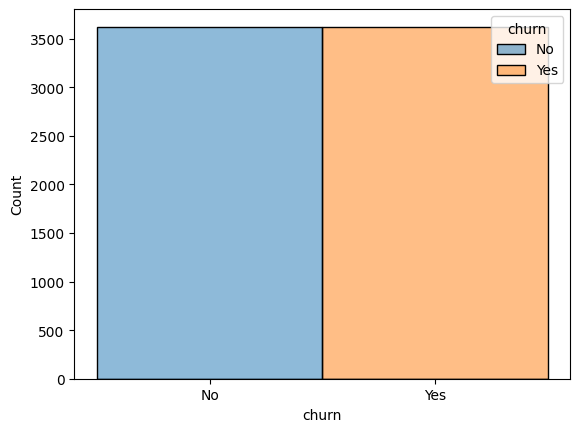

In [135]:
sns.histplot(data=data_ros, x='churn', hue='churn')

### SMOTE

In [136]:
def sm_resample(data, col_to_drop):
    data_copy = data.copy()

    sm = SMOTE(random_state=42)
    X_sm, y_sm = sm.fit_resample(data_copy.drop(col_to_drop, axis=1), data_copy[col_to_drop])
    data_sm = pd.concat([X_sm, y_sm], axis=1)

    return data_sm

In [137]:
data_sm = sm_resample(data=train_set, col_to_drop='churn')

<Axes: xlabel='churn', ylabel='Count'>

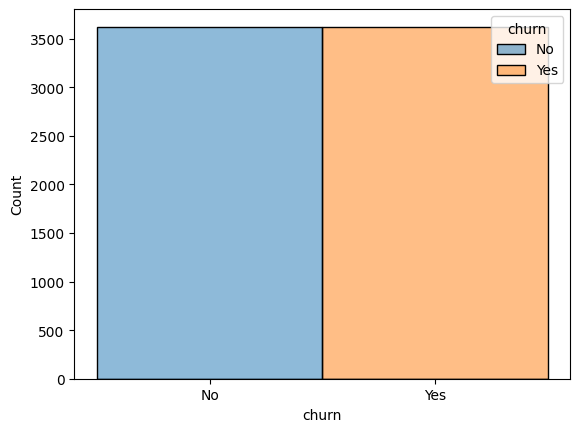

In [138]:
sns.histplot(data=data_sm, x='churn', hue='churn')

## Label Encoding

In [139]:
def le_fit(data, le_path):
    le_encoder = LabelEncoder()
    le_encoder.fit(data)
    joblib.dump(le_encoder, le_path)

    return le_encoder

In [140]:
le_encoder = le_fit(data=params['range_churn'], le_path=params['le_path'])

In [141]:
def le_transform(data, config_file):
    data_copy = data.copy()
    le_encoder = joblib.load(config_file['le_path'])
    
    if len(set(data_copy.unique()) - set(le_encoder.classes_) | set(le_encoder.classes_) - set(data_copy.unique())) == 0:
        data_copy = le_encoder.transform(data_copy)
    else:
        raise RuntimeError('Check category in label data and label encoder')

    return data_copy

In [142]:
train_set['churn'] = le_transform(data=train_set['churn'], config_file=params)

In [143]:
train_set['churn']

5557    0
2270    1
6930    1
2257    0
898     1
       ..
4250    0
1488    0
6303    0
2710    0
5639    0
Name: churn, Length: 4930, dtype: int64

In [144]:
data_rus['churn'] = le_transform(data=data_rus['churn'], config_file=params)

In [145]:
data_ros['churn'] = le_transform(data=data_ros['churn'], config_file=params)

In [146]:
data_sm['churn'] = le_transform(data=data_sm['churn'], config_file=params)

In [147]:
valid_set['churn'] = le_transform(data=valid_set['churn'], config_file=params)

In [148]:
test_set['churn'] = le_transform(data=test_set['churn'], config_file=params)

## Feature Selection

### Train Set Standardization

In [149]:
def fit_scaler(data):
    """
    Fit the StandardScaler to the data.
    Args:
        data (pd.DataFrame): The input data to be fitted by the scaler.

    Returns:
        scaler (StandardScaler): Fitted StandardScaler object.
    """
    # initialize the StandardScaler
    scaler = StandardScaler()

    # fit the scaler to the data
    scaler.fit(data)

    return scaler

In [150]:
# fit scaler using df_eda data
scaler = fit_scaler(data = train_set.drop(columns='churn'))

In [151]:
def transform_scaler(data, scaler):
    """
    Transform the data using the fitted StandardScaler.
    Args:
        data (pd.DataFrame): The data to be transformed.
        scaler (StandardScaler): Fitted scaler.

    Returns:
        df_scaled (pd.DataFrame): Scaled data with the same index and columns.
    """
    # Transform the data using the fitted scaler
    df_scaled = pd.DataFrame(scaler.transform(data))

    # Set the index and columns of the scaled DataFrame
    df_scaled.index = data.index
    df_scaled.columns = data.columns

    print(f'Data shape: {data.shape}')

    return df_scaled

In [152]:
# transform scaler using df_rfm_data data
X_scaled = transform_scaler(data = train_set.drop(columns='churn'),
                            scaler = scaler)

X_scaled.head()

Data shape: (4930, 30)


,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,paperless_billing_Yes,contract_One year,contract_Two year,streaming_movies_No internet service,streaming_movies_Yes,streaming_tv_No internet service,streaming_tv_Yes,...,multiple_lines_No phone service,multiple_lines_Yes,phone_service_Yes,dependents_Yes,partner_Yes,senior_citizen_Yes,gender_Male,tenure_months,monthly_charges,total_charges
5557,-0.525557,1.407357,-0.543123,-1.205295,-0.515170,-0.564701,-0.525871,-0.802422,-0.525871,1.240938,...,-0.334459,-0.856787,0.334459,-0.650862,-0.962957,-0.438147,-1.005288,-1.114728,0.504286,-0.836504
2270,-0.525557,1.407357,-0.543123,0.829672,-0.515170,-0.564701,-0.525871,-0.802422,-0.525871,1.240938,...,-0.334459,-0.856787,0.334459,-0.650862,-0.962957,2.282338,-1.005288,-1.195884,0.724189,-0.907742
6930,1.902743,-0.710552,-0.543123,0.829672,-0.515170,-0.564701,-0.525871,-0.802422,-0.525871,-0.805842,...,-0.334459,1.167151,0.334459,-0.650862,1.038468,-0.438147,-1.005288,-1.195884,0.337292,-0.909574
2257,1.902743,-0.710552,-0.543123,-1.205295,1.941106,-0.564701,-0.525871,1.246227,-0.525871,1.240938,...,-0.334459,1.167151,0.334459,-0.650862,-0.962957,-0.438147,-1.005288,1.117066,0.515860,1.110332
898,-0.525557,-0.710552,-0.543123,0.829672,-0.515170,-0.564701,-0.525871,1.246227,-0.525871,1.240938,...,-0.334459,-0.856787,0.334459,-0.650862,-0.962957,-0.438147,-1.005288,-0.830682,1.122660,-0.515129


### Lasso Regression

In [153]:
def feature_selection(estimator, X_train, y_train):
    """
    Fits the given estimator to the training data, computes training and cross-validation
    scores, and extracts the model coefficients.

    Parameters
    ----------
    estimator : sklearn estimator
        The regression model to be fitted (e.g., Lasso).

    X_train : pandas DataFrame
        The training features used to fit the model.

    y_train : pandas Series or numpy array
        The target variable corresponding to the training features.

    Returns
    -------
    estimator : sklearn estimator
        The fitted estimator with learned parameters.

    train_score : float
        The mean squared error of the model on the training data.

    cv_score : float
        The average negative mean squared error obtained from cross-validation.

    estimator_params_df : pandas DataFrame
        A DataFrame containing the model coefficients and the constant term.
    """
    # fit the model
    estimator.fit(X_train, y_train)

    # predict
    y_pred_train = estimator.predict(X_train)
    train_score = mean_squared_error(y_true=y_train, y_pred=y_pred_train)

    # cross validation
    valid_scores = cross_val_score(estimator=estimator,
                                   X=X_train,
                                   y=y_train,
                                   cv=5,
                                   scoring='neg_mean_squared_error')
    cv_score = -np.mean(valid_scores)

    # extract coefficient
    coef_ = estimator.coef_
    intercept_ = estimator.intercept_
    estimator_params = np.append(coef_, intercept_)

    # create DataFrame for coefficients
    estimator_params_df = pd.DataFrame(estimator_params,
                                       index=list(X_train.columns) + ['constant'],
                                       columns=['coefficient'])

    return estimator, train_score, cv_score, estimator_params_df

In [154]:
alpha = np.linspace(0, 10, 10)

# To store results
mse_train_list = []
mse_cv_list = []
model_list = []

# Loop over different alpha values
for i in alpha:
    model_i, train_score_i, \
        cv_score_i, model_param_i = feature_selection(estimator=Lasso(alpha=i),
                                                      X_train=X_scaled,
                                                      y_train=train_set['churn'])

    mse_train_list.append(train_score_i)
    mse_cv_list.append(cv_score_i)
    model_list.append(model_param_i)

/home/febbyngrni/telco_churn/.venv_churn/lib/python3.10/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/febbyngrni/telco_churn/.venv_churn/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/febbyngrni/telco_churn/.venv_churn/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.427e+02, tolerance: 9.610e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemente

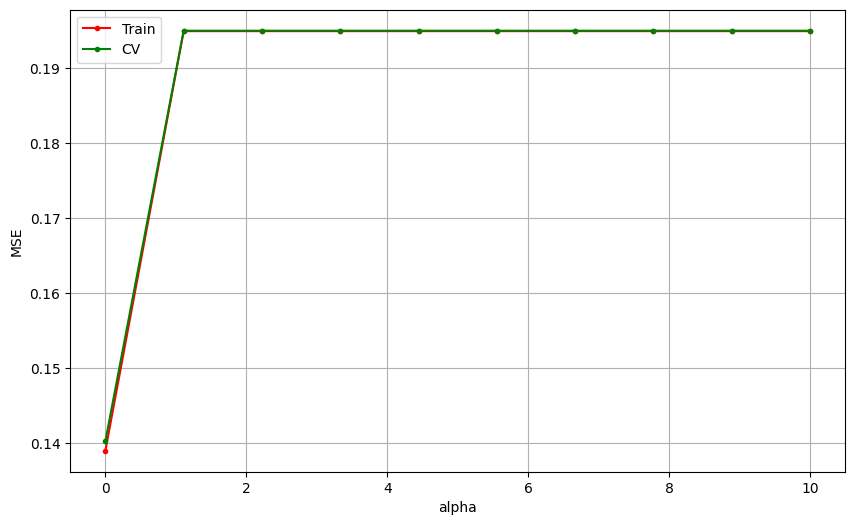

In [155]:
# create subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# plot error
ax.plot(alpha, mse_train_list, c='r', marker='.', label='Train')
ax.plot(alpha, mse_cv_list, c='g', marker='.', label='CV')
ax.set_xlabel('alpha')
ax.set_ylabel('MSE')

plt.grid()
plt.legend()
plt.show()

In [157]:
# find the index of the minimum cross-validated mse
best_index = np.argmin(mse_cv_list)

# retrieve the best alpha value and corresponding cross-validated mse
best_alpha = alpha[best_index]
best_lasso_cv = mse_cv_list[best_index]

# Output the best alpha value and the corresponding cross-validated mse
best_alpha, best_lasso_cv

(np.float64(0.0), np.float64(0.14031246617246823))

In [158]:
# best model
best_model_lasso = model_list[best_index]
best_model_lasso

,coefficient
payment_method_Credit card (automatic),-0.000981
payment_method_Electronic check,0.036608
payment_method_Mailed check,0.004971
paperless_billing_Yes,0.025666
contract_One year,-0.045801
contract_Two year,-0.032487
streaming_movies_No internet service,-0.191455
streaming_movies_Yes,0.047210
streaming_tv_No internet service,0.019921
streaming_tv_Yes,0.040328


## Dump Dataset

In [156]:
joblib.dump(data_rus.drop(columns='churn'), params['data_rus_path'][0])
joblib.dump(data_rus['churn'], params['data_rus_path'][1])

joblib.dump(data_ros.drop(columns='churn'), params['data_ros_path'][0])
joblib.dump(data_ros['churn'], params['data_ros_path'][1])

joblib.dump(data_sm.drop(columns='churn'), params['data_sm_path'][0])
joblib.dump(data_sm['churn'], params['data_sm_path'][1])

joblib.dump(valid_set.drop(columns='churn'), params['valid_feng_set_path'][0])
joblib.dump(valid_set['churn'], params['valid_feng_set_path'][1])

joblib.dump(test_set.drop(columns='churn'), params['test_feng_set_path'][0])
joblib.dump(test_set['churn'], params['test_feng_set_path'][1])

['../data/processed/y_test_feng.pkl']